# Basic basemap plots
This notebook is created on the basis from https://github.com/matplotlib/basemap/blob/master/examples/fillstates.py

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase
import pandas as pd
import numpy as np
from matplotlib.colors import rgb2hex, Normalize
pd.options.display.max_rows = 20

In [2]:
class Statesmap(object):
    def __init__(self, figsize = (8, 6)):
        '''Initialize a figure and load the map of us states'''
        self.fig = plt.figure(figsize = figsize, dpi = 300)
        self.ax = self.fig.subplots()
        self.load_dicts()
    
    def load_dicts(self):
        '''Load state names and their corresponding abbreviation into a dictionary
        '''
        states = pd.read_csv('src/states.csv', sep = '\t')
        self.full2ab = states.set_index('State').to_dict()['Abbreviation']
        self.ab2full = states.set_index('Abbreviation').to_dict()['State']
        
    def plot(self, data, scale = 'linear', colormap = plt.cm.jet):
        '''plot data
        
        data: a dictionary of data, whose key is the state name, either full name
        or abbrevation.
        '''
        self.add_states()
        colors, statenames, norm = self.assign_colors(data, scale = scale, colormap = colormap)
        self.add_patches(colors, statenames)
        self.add_text(statenames)
        
        light_gray = [0.8]*3  # define light gray color RGB
        x1,y1 = self.m_([-190,-183,-180,-180,-175,-171,-171],[29,29,26,26,26,22,20])
        x2,y2 = self.m_([-180,-180,-177],[26,23,20])  # these numbers are fine-tuned manually
        self.m_.plot(x1,y1,color=light_gray,linewidth=0.8)  # do not change them drastically
        self.m_.plot(x2,y2,color=light_gray,linewidth=0.8)

        #%% ---------   Show color bar  ---------------------------------------
        ax_c = self.fig.add_axes([1, 0.1, 0.03, 0.8])
        cb = ColorbarBase(ax_c,cmap=colormap,norm=norm,orientation='vertical',
                  label=' ')
        
    def add_states(self):
        '''Load the shape of US states'''
        # Lambert Conformal map of lower 48 states.
        self.m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
                         projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
        # Mercator projection, for Alaska and Hawaii
        self.m_ = Basemap(llcrnrlon=-190,llcrnrlat=20,urcrnrlon=-143,urcrnrlat=46,
            projection='merc',lat_ts=20)  # do not change these numbers
        # draw state boundaries  
        shp_info = self.m.readshapefile('src/st99_d00','states',drawbounds=True,
                           linewidth=0.45,color='gray')
        shp_info_ = self.m_.readshapefile('src/st99_d00','states',drawbounds=False)
    
    def assign_colors(self, data, scale, colormap):
        '''Assign a color to each state according to its data'''
        colors = {}
        statenames = []
        vmin = min(data.values())
        vmin *= 0.95 if vmin > 0 else 1.05
        vmax = max(data.values())
        vmax *= 1.05 if vmax > 0 else 0.95
        norm = Normalize(vmin = vmin, vmax = vmax)
        for shapedict in self.m.states_info:
            statename = shapedict['NAME']
            if statename not in ['District of Columbia','Puerto Rico'] and (statename in data
                                                        or self.full2ab[statename] in data):
                dens = data.get(statename, data.get(self.full2ab[statename], np.nan))
                if scale == 'linear':
                    colors[statename] = colormap((dens-vmin)/(vmax-vmin))[:3]
                elif scale == 'sqrt':
                    colors[statename] = colormap
            statenames.append(statename)
        return colors, statenames, norm
    
    def add_patches(self, colors, statenames):
        '''Add state patches to the map'''
        # add 48 states
        for ind, seg in enumerate(self.m.states):
            if statenames[ind] not in ['Puerto Rico', 'District of Columbia'] and statenames[ind] in colors:
                color = rgb2hex(colors[statenames[ind]])
                poly = Polygon(seg, facecolor=color, edgecolor=color)
                self.ax.add_patch(poly)
        # some recommended setting to plot Hawaii and Alaska
        AREA_1 = 0.005  # exclude small Hawaiian islands that are smaller than AREA_1
        AREA_2 = AREA_1 * 30.0  # exclude Alaskan islands that are smaller than AREA_2
        AK_SCALE = 0.19  # scale down Alaska to show as a map inset
        HI_OFFSET_X = -1900000  # X coordinate offset amount to move Hawaii "beneath" Texas
        HI_OFFSET_Y = 250000    # similar to above: Y offset for Hawaii
        AK_OFFSET_X = -250000   # X offset for Alaska (These four values are obtained
        AK_OFFSET_Y = -750000   # via manual trial and error, thus changing them is not recommended.)
        for nshape, shapedict in enumerate(self.m_.states_info):  
            if shapedict['NAME'] in ['Alaska', 'Hawaii']:
                seg = self.m_.states[int(shapedict['SHAPENUM'] - 1)]
                if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > AREA_1:
                    seg = [(x + HI_OFFSET_X, y + HI_OFFSET_Y) for x, y in seg]
                elif shapedict['NAME'] == 'Alaska' and float(shapedict['AREA']) > AREA_2:
                    seg = [(x*AK_SCALE + AK_OFFSET_X, y*AK_SCALE + AK_OFFSET_Y)\
                           for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]]) if shapedict['NAME'] in colors else 'w'
                poly = Polygon(seg, facecolor=color, edgecolor='gray', linewidth=.45)
                self.ax.add_patch(poly)
    
    def add_text(self, statenames):
        '''Add state abbrevations'''
        printed_names = set()
        wi_index = 0
        mi_index = 0
        for ind, seg in enumerate(self.m.states):
            statename = statenames[ind]
            if statename in ['District of Columbia', 'Puerto Rico'] or statename in printed_names:
                continue
            shortname = self.full2ab[statename]
            if shortname == 'MI' and mi_index != 3:
                mi_index += 1
                continue
            if shortname == 'WI' and wi_index != 2:
                wi_index += 1
                continue
            x, y = np.array(seg).mean(axis=0)
            if shortname == 'HI':
                plt.text(1500000, 200000, shortname)
            elif shortname == 'AK':
                plt.text(450000, 550000, shortname)
            elif shortname in {'ND','SD','NE','KS'}:
                plt.text(x-200000, y, shortname, ha="center")
            elif shortname in {'LA', 'AR'}:
                plt.text(x-100000, y, shortname, ha="center")
            elif shortname in {'AZ','WA','MT','FL', 'MS'}:
                plt.text(x+100000, y, shortname, ha="center")
            elif shortname in {'OR','ID'}:
                plt.text(x, y-100000, shortname, ha="center")
            elif shortname in {'KY','TN', 'WV'}:
                plt.text(x, y-50000, shortname, ha="center")
            elif shortname == 'VA':
                plt.text(x+50000, y-50000, shortname, ha="center")
            elif shortname == 'PA':
                plt.text(x-50000, y-50000, shortname, ha="center")
            elif shortname in {'MD', 'CT'}:
                plt.annotate(shortname, xy = (x, y), xytext = (x+250000, y-300000), 
                             arrowprops = {'arrowstyle': '-', 'color': 'gray'})
            elif shortname in {'DE', 'NJ', 'RI'}:
                plt.annotate(shortname, xy = (x, y), xytext = (x+200000, y-200000), 
                             arrowprops = {'arrowstyle': '-', 'color': 'gray'})
            elif shortname == 'MA':
                plt.annotate(shortname, xy = (x, y), xytext = (x+100000, y+100000), 
                             arrowprops = {'arrowstyle': '-', 'color': 'gray'})
            elif shortname == 'VT':
                plt.annotate(shortname, xy = (x, y), xytext = (x-300000, y+200000), 
                             arrowprops = {'arrowstyle': '-', 'color': 'gray'})
            elif shortname == 'NH':
                plt.annotate(shortname, xy = (x, y), xytext = (x-200000, y+200000), 
                             arrowprops = {'arrowstyle': '-', 'color': 'gray'})
            else:
                plt.text(x, y, shortname, ha="center")
            printed_names.add(statename)

In [3]:
# create some fake data to plot
states = pd.read_csv('src/states.csv', sep = '\t')
states['dens'] = states['State'].apply(lambda x: np.random.random())
dens_dict = states[['State', 'dens']].set_index('State').to_dict()['dens']

/Users/yuzhang/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yuzhang/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


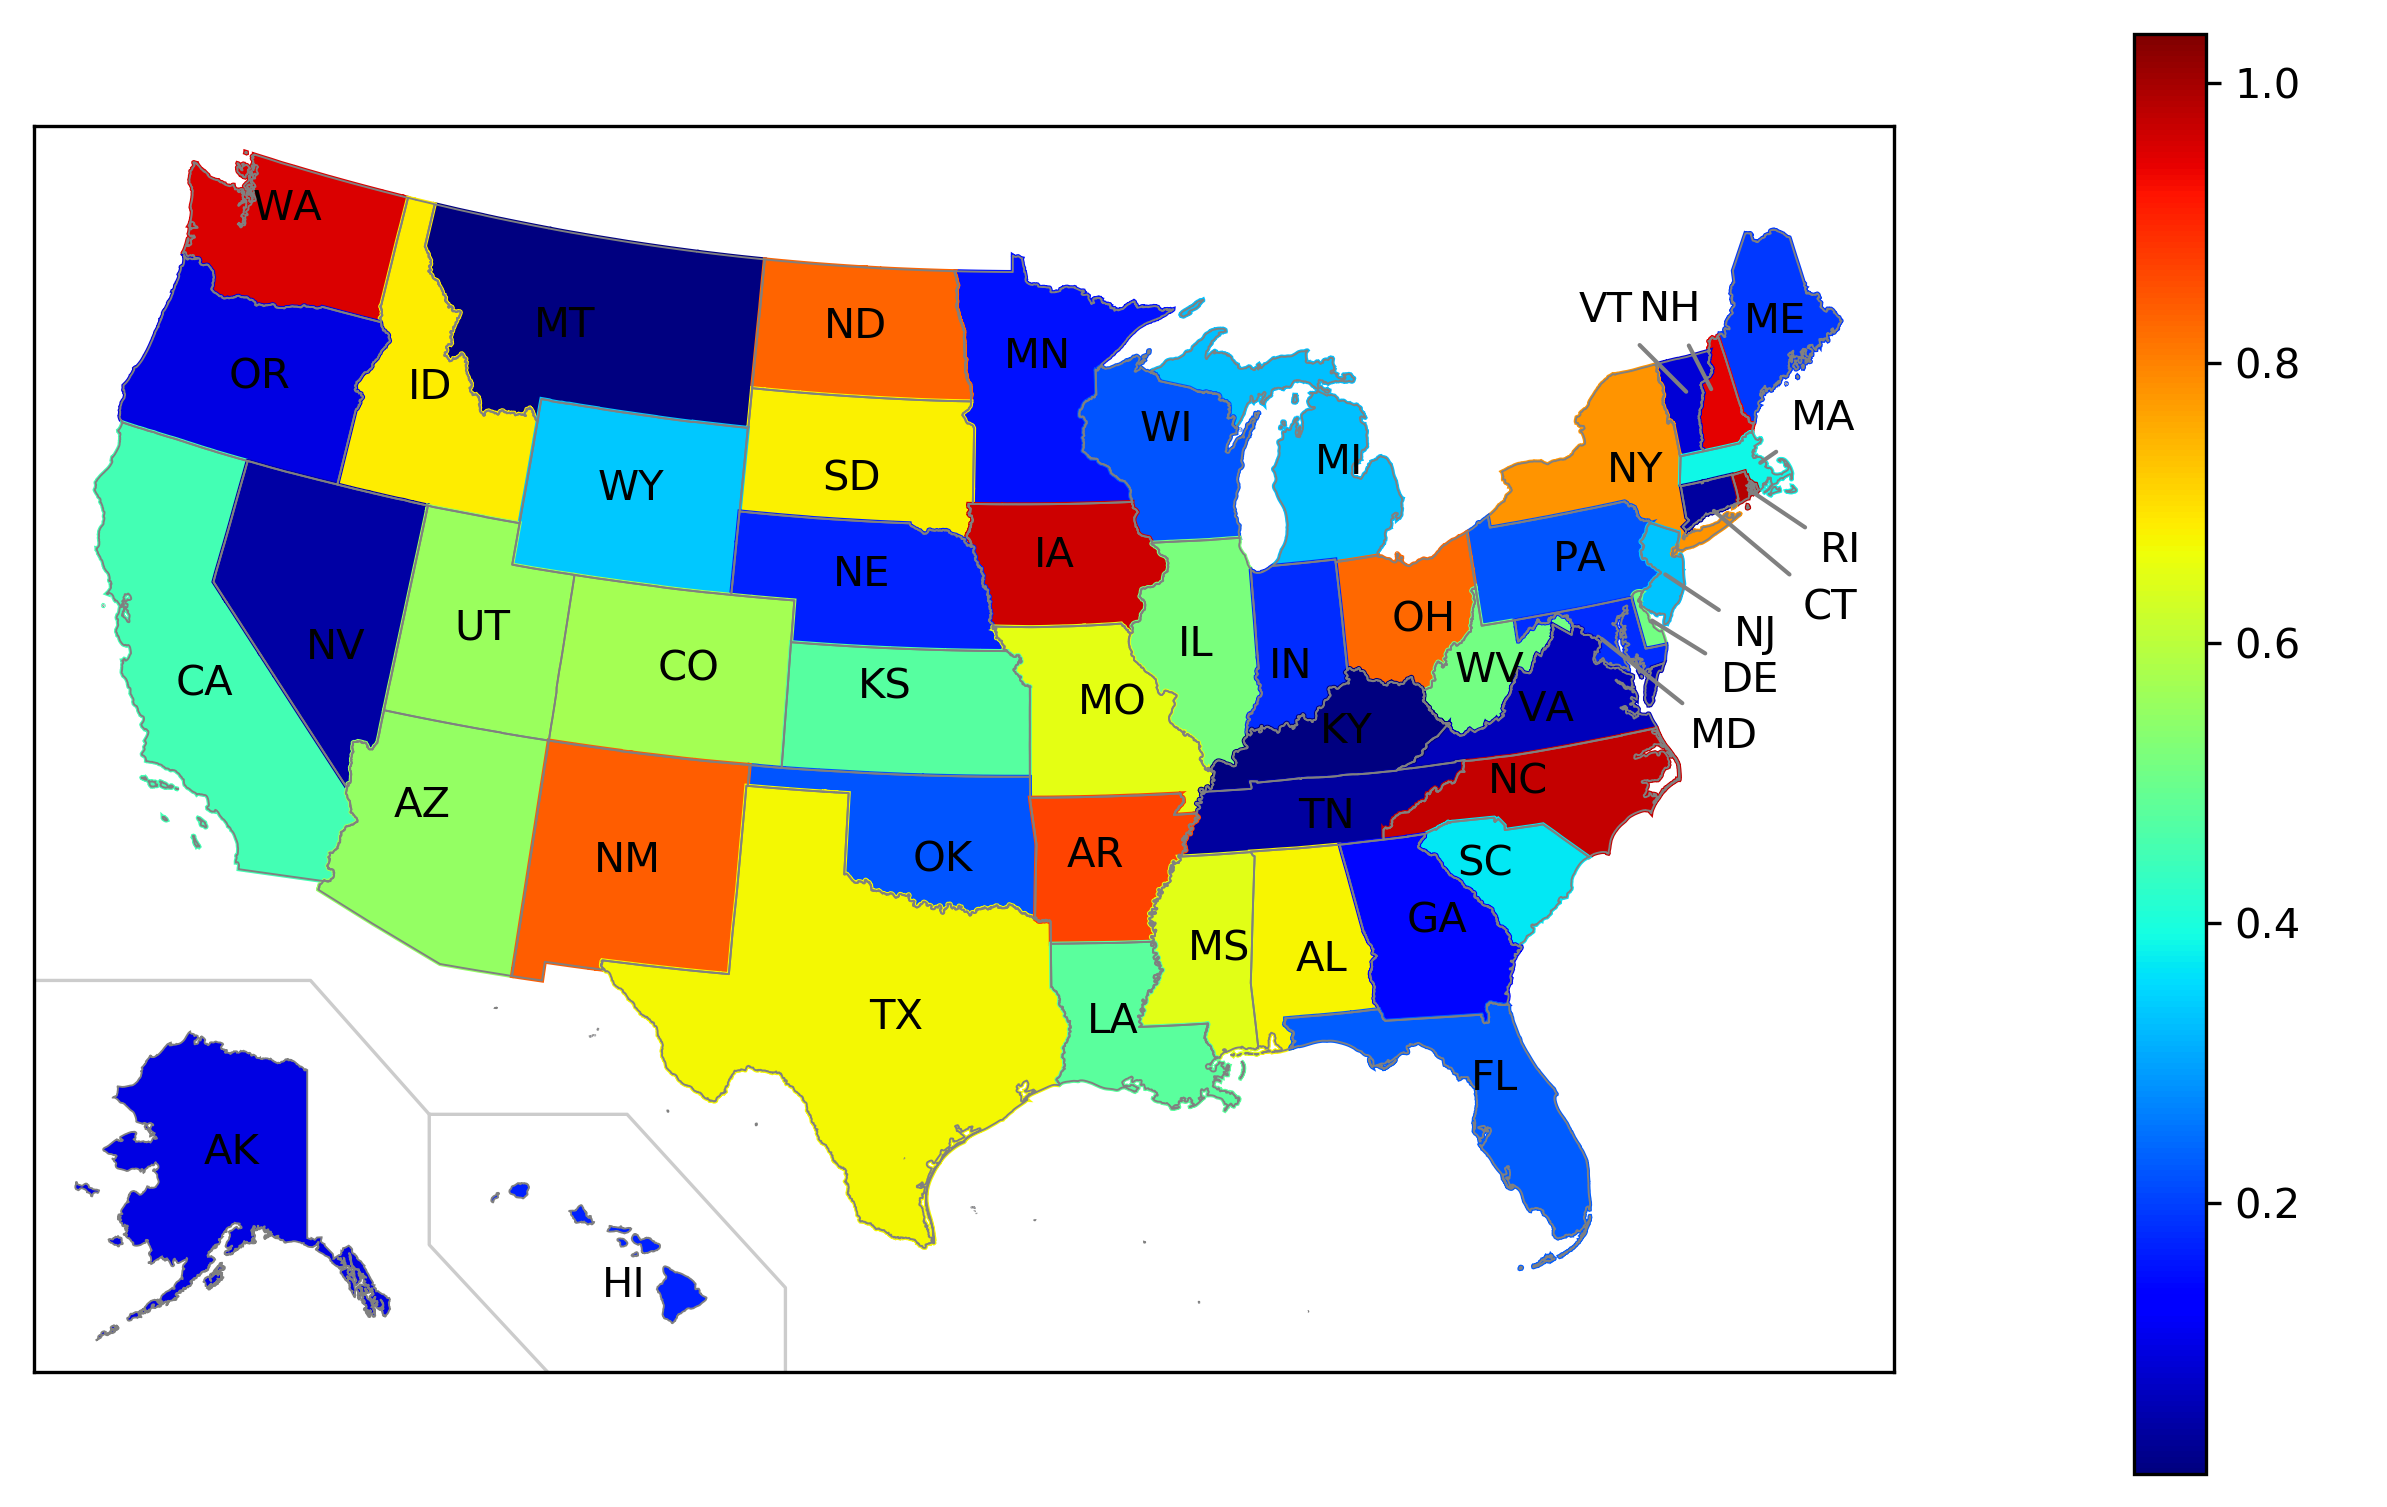

In [4]:
mymap = Statesmap()
mymap.plot(dens_dict)

In [7]:
mymap.fig.tight_layout()
mymap.fig.savefig('Basemap_example.pdf', bbox_inches='tight')

/Users/yuzhang/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
